In [337]:
from pathlib import Path
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

DATA_PATH = Path("iq_int16.pcm")  


def read_iq_int16(path: Path, normalize: bool = True) -> np.ndarray:
    """Читает int16 IQ-файл и возвращает комплексный массив."""
    raw = np.fromfile(path, dtype=np.int16)
    if raw.size < 2:
        raise ValueError("Файл должен содержать хотя бы одну пару I/Q отсчётов.")
    if raw.size % 2:
        raw = raw[:-1]
    i = raw[0::2].astype(np.float32)
    q = raw[1::2].astype(np.float32)
    iq = i + 1j * q
    if normalize:
        peak = np.max(np.abs(iq))
        if peak > 0:
            iq = iq / peak
    return iq.astype(np.complex64)



In [338]:
try:
    iq_samples = read_iq_int16(DATA_PATH)
    print(f"Загружено {iq_samples.size} комплексных отсчётов из {DATA_PATH.name}")
    print(f"Пример первых 5 отсчётов: {iq_samples[:5]}")
except FileNotFoundError:
    iq_samples = np.array([], dtype=np.complex64)
    print(f"Файл {DATA_PATH} не найден. Укажите корректный путь в переменной DATA_PATH.")
except Exception as exc:
    iq_samples = np.array([], dtype=np.complex64)
    print(f"Ошибка при чтении: {exc}")



Загружено 100000 комплексных отсчётов из iq_int16.pcm
Пример первых 5 отсчётов: [ 0.24574143-0.77171683j -0.23794125+0.23271728j  0.10905939+0.09031033j
  0.2526113 -0.72391385j -0.37269112-0.13682516j]


In [339]:
def apply_integer_delay(signal: np.ndarray, delay: int) -> np.ndarray:
    if signal.size == 0 or delay == 0:
        return signal
    if delay > 0:
        if delay >= signal.size:
            return np.array([], dtype=signal.dtype)
        return signal[delay:]
    shift = abs(delay)
    padded = np.pad(signal, (shift, 0), mode="constant")
    return padded[: signal.size]


def apply_fractional_delay_lagrange(signal: np.ndarray, frac_delay: float) -> np.ndarray:
    if signal.size == 0 or abs(frac_delay) < 1e-9:
        return signal
    n = np.arange(signal.size, dtype=np.float32)
    interpolator = interp1d(
        n,
        signal,
        kind="cubic",
        bounds_error=False,
        fill_value="extrapolate",
        assume_sorted=True,
    )
    shifted = interpolator(n - frac_delay)
    return shifted.astype(signal.dtype)


def compensate_delay_lagrange(signal: np.ndarray, delay_samples: float) -> np.ndarray:
    if signal.size == 0 or abs(delay_samples) < 1e-9:
        return signal
    int_delay = int(np.floor(delay_samples))
    frac_delay = float(delay_samples - int_delay)
    delayed = apply_integer_delay(signal, int_delay)
    if abs(frac_delay) > 1e-9:
        delayed = apply_fractional_delay_lagrange(delayed, frac_delay)
    return delayed



In [340]:
def slice_symbols(signal: np.ndarray, sps: int, offset: int = 0, max_points: int | None = None) -> np.ndarray:
    """Выбирает по одному отсчёту на символ из передискретизированного сигнала."""
    if signal.size == 0 or sps <= 0:
        return np.array([], dtype=np.complex64)
    start = max(offset, 0)
    symbols = signal[start::sps]
    if max_points is not None:
        symbols = symbols[:max_points]
    return symbols



In [341]:

f_rel = -0.00026

if iq_samples.size and not np.isclose(f_rel, 0.0):
    n = np.arange(iq_samples.size, dtype=np.float32)
    iq_baseband = iq_samples * np.exp(-1j * 2 * np.pi * f_rel * n)
    print("Компенсация по оценённому f_rel выполнена.")
else:
    iq_baseband = iq_samples.copy()
    print("Компенсация не выполнялась (f_rel≈0 или нет данных).")



Компенсация по оценённому f_rel выполнена.


In [342]:
X0 = -0.06  # задержка в отсчётах (положительная -> сдвигаем сигнал вперёд во времени)

if iq_baseband.size:
    iq_time_aligned = compensate_delay_lagrange(iq_baseband, X0)
    print(f"Компенсация задержки на {X0:+.3f} отсчётов выполнена.")
    print(f"Пример первых 5 отсчётов после выравнивания: {iq_time_aligned[:5]}")
else:
    iq_time_aligned = iq_baseband.copy()
    print("Нет данных для компенсации задержки.")



Компенсация задержки на -0.060 отсчётов выполнена.
Пример первых 5 отсчётов после выравнивания: [-2.8715465 +5.554984j    0.07563342-0.1618985j   0.21525396-0.72575164j
 -0.24244708+0.270732j    0.13985284+0.03404369j]


In [343]:
SPS = 1  # количество отсчётов на символ, задаётся пользователем
SYMBOL_OFFSET = 0  # смещение выборки внутри символа (0 ... SPS-1)

symbols = slice_symbols(iq_time_aligned, SPS, offset=SYMBOL_OFFSET, max_points=MAX_POINTS)
print(f"Выбрано символов для созвездия: {symbols.size}")



Выбрано символов для созвездия: 10000


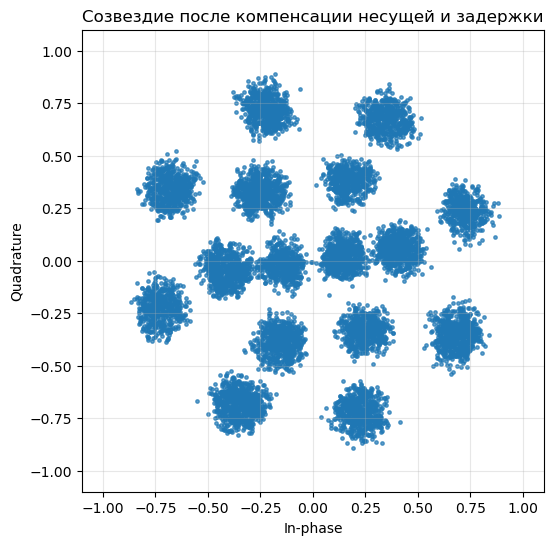

In [344]:
MAX_POINTS = 10000

source_signal = (
    symbols if 'symbols' in locals() and symbols.size else (
        iq_time_aligned if 'iq_time_aligned' in locals() and iq_time_aligned.size else iq_baseband
    )
)
points = source_signal[:MAX_POINTS] if source_signal.size else np.array([], dtype=np.complex64)

if points.size:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(points.real, points.imag, s=6, alpha=0.7)
    title = "Созвездие после компенсации несущей и задержки" if 'iq_time_aligned' in locals() else "Созвездие после компенсации несущей"
    ax.set_title(title)
    ax.set_xlabel("In-phase")
    ax.set_ylabel("Quadrature")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect("equal", "box")
    plt.show()
else:
    print("Нет данных для отображения. Запустите предыдущие ячейки.")

